Defaulting to user installation because normal site-packages is not writeable
Scores for example 0


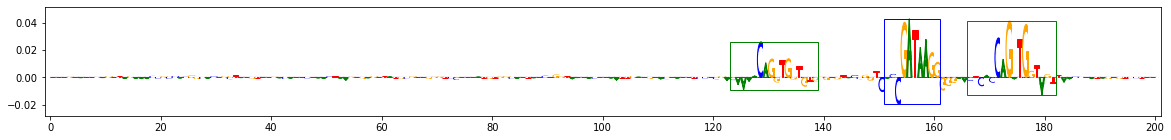

Scores for example 3


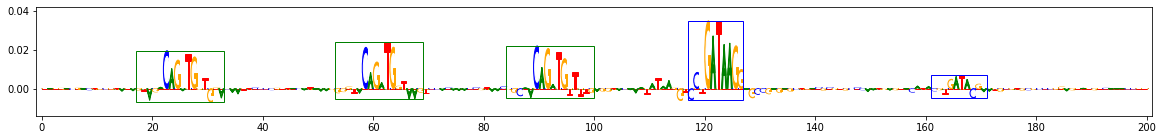

Scores for example 9


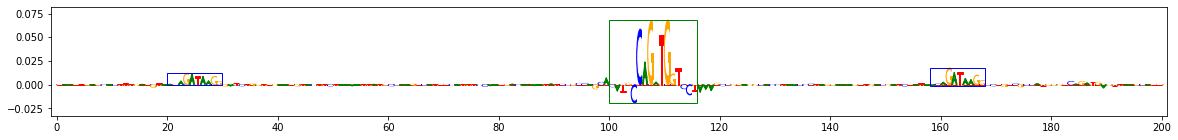

In [2]:
! [[ ! -f sequences.simdata.gz ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/db919b12f750e5844402153233249bb3d24e9e9a/deeplift/genomics/sequences.simdata.gz
! [[ ! -f keras2_conv1d_record_5_model_PQzyq_modelJson.json ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/b6e1d69/deeplift/genomics/keras2_conv1d_record_5_model_PQzyq_modelJson.json
! [[ ! -f keras2_conv1d_record_5_model_PQzyq_modelWeights.h5 ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/b6e1d69/deeplift/genomics/keras2_conv1d_record_5_model_PQzyq_modelWeights.h5
! [[ ! -f test.txt.gz ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/9aadb769735c60eb90f7d3d896632ac749a1bdd2/deeplift/genomics/test.txt.gz

! pip install simdna deeplift

import gzip

import simdna.synthetic as synthetic

data_filename = "sequences.simdata.gz"

# read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz", "rb")
ids_to_load = [x.decode("utf-8").rstrip("\n") for x in test_ids_fh]
data = synthetic.read_simdata_file(data_filename, ids_to_load=ids_to_load)

import numpy as np


# this is set up for 1d convolutions where examples
# have dimensions (len, num_channels)
# the channel axis is the axis for one-hot encoding.
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence), 4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(
        zeros_array=to_return, sequence=sequence, one_hot_axis=1
    )
    return to_return


def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis == 0 or one_hot_axis == 1
    if one_hot_axis == 0:
        assert zeros_array.shape[1] == len(sequence)
    elif one_hot_axis == 1:
        assert zeros_array.shape[0] == len(sequence)
    # will mutate zeros_array
    for i, char in enumerate(sequence):
        if char == "A" or char == "a":
            char_idx = 0
        elif char == "C" or char == "c":
            char_idx = 1
        elif char == "G" or char == "g":
            char_idx = 2
        elif char == "T" or char == "t":
            char_idx = 3
        elif char == "N" or char == "n":
            continue  # leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: " + str(char))
        if one_hot_axis == 0:
            zeros_array[char_idx, i] = 1
        elif one_hot_axis == 1:
            zeros_array[i, char_idx] = 1


onehot_data = np.array(
    [one_hot_encode_along_channel_axis(seq) for seq in data.sequences]
)

from keras.models import model_from_json

# load the keras model
keras_model_weights = "keras2_conv1d_record_5_model_PQzyq_modelWeights.h5"
keras_model_json = "keras2_conv1d_record_5_model_PQzyq_modelJson.json"

keras_model = model_from_json(open(keras_model_json).read())
keras_model.load_weights(keras_model_weights)

from deeplift.dinuc_shuffle import dinuc_shuffle

def shuffle_several_times(s):
    s = np.squeeze(s)
    return dinuc_shuffle(s, num_shufs=100)

import shap

np.random.seed(1)

seqs_to_explain = onehot_data[[0, 3, 9]]  # these three are positive for task 0
dinuc_shuff_explainer = shap.DeepExplainer(
    (keras_model.input, keras_model.output[:, 0]), shuffle_several_times
)
raw_shap_explanations = dinuc_shuff_explainer.shap_values(
    seqs_to_explain, check_additivity=False
)

from deeplift.visualization import viz_sequence

# project the importance at each position onto the base that's actually present
dinuc_shuff_explanations = (
    np.sum(raw_shap_explanations, axis=-1)[:, :, None] * seqs_to_explain[:, :, None]
)
for idx, dinuc_shuff_explanation in zip([0, 3, 9], dinuc_shuff_explanations):
    print("Scores for example", idx)
    highlight = {
        "blue": [
            (embedding.startPos, embedding.startPos + len(embedding.what))
            for embedding in data.embeddings[idx]
            if "GATA_disc1" in embedding.what.getDescription()
        ],
        "green": [
            (embedding.startPos, embedding.startPos + len(embedding.what))
            for embedding in data.embeddings[idx]
            if "TAL1_known1" in embedding.what.getDescription()
        ],
    }
    viz_sequence.plot_weights(
        dinuc_shuff_explanation, subticks_frequency=20, highlight=highlight
    )